In [1]:
import torch
from torch.autograd import Variable

from scipy.misc import imresize
from scipy.ndimage.interpolation import zoom
import numpy as np
import pylab as plt
import imageio
import os

import cv2

from models import DispNet, MaskNet
from generate_volume import *



In [2]:
num_d = 16

#16 planes sampled from our training set
depths_range = [1.1162109375, 1.353515625, 1.595703125, 1.8359375, 2.078125, 2.375, 2.7265625, 3.15234375,
            3.701171875, 4.5234375, 5.42578125, 6.2890625, 8.0234375, 11.765625, 17.859375, 25.703126907348633]

In [3]:
#load pretrained models
pretrained_dispnet = 'dispnet_model_best.pth.tar'
pretrained_masknet = 'masknet_model_best.pth.tar'

disp_net = DispNet(num_d).cuda()
weights = torch.load(pretrained_dispnet)
disp_net.load_state_dict(weights['state_dict'])
disp_net.eval()


mask_net = MaskNet(num_d).cuda()
weights = torch.load(pretrained_masknet)
mask_net.load_state_dict(weights['state_dict'])
mask_net.eval()

MaskNet(
  (conv1): Sequential(
    (0): Conv2d(51, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=

In [4]:
with torch.no_grad():
    r_img = imageio.imread('examples/0000.png')

    n_imgs = [imageio.imread('examples/0001.png')]

    poses = np.loadtxt('examples/pose.txt')

    r_pose = poses[0].reshape(4,4)

    n_poses = [poses[1].reshape(4,4)]

    rel_poses = [np.dot(n_pose, np.linalg.inv(r_pose)) for n_pose in n_poses]

    rel_poses_var = [Variable(torch.from_numpy(pose).unsqueeze(0).float().cuda()) for pose in rel_poses]


    intrinsics = np.genfromtxt('examples/cam.txt', delimiter=',').astype(np.float32).reshape((3, 3))


    intrinsics_inv = torch.from_numpy(np.linalg.inv(intrinsics)).unsqueeze(0)
    intrinsics = torch.from_numpy(intrinsics).unsqueeze(0)

    r_img = np.transpose(r_img, (2, 0, 1))
    n_imgs = [np.transpose(img, (2,0,1)) for img in n_imgs]

    r_img = (r_img/255 - 0.5)/0.5
    r_img_var = torch.from_numpy(r_img).unsqueeze(0).float().cuda()



    n_imgs_var = []
    for i, img in enumerate(n_imgs):
        img = (img/255 - 0.5)/0.5
        img = torch.from_numpy(img).unsqueeze(0).float().cuda()
        n_imgs_var.append(img)

    intrinsics_var = Variable(intrinsics.float().cuda())
    intrinsics_inv_var = Variable(intrinsics_inv.float().cuda())

    pred_masks = []

    for n_idx, n_img in enumerate(n_imgs_var):
        pose = rel_poses_var[n_idx]
        volume = generate_volume(r_img_var, n_img, intrinsics_var, intrinsics_inv_var, pose, depths_range)
        pred_mask = mask_net(volume)  # B,D,H,w
        pred_masks.append(pred_mask)


    stacked_masks = torch.stack(pred_masks, dim=1)  # B,N,D,H,W
    pool_mask = torch.mean(stacked_masks, dim=1)  # B,D,H,W


    pred_disp = disp_net(torch.cat((r_img_var, pool_mask), dim=1)).cpu().numpy()[0,0]



/u/64/houy2/unix/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/u/64/houy2/unix/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/u/64/houy2/unix/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(-0.5, 319.5, 239.5, -0.5)

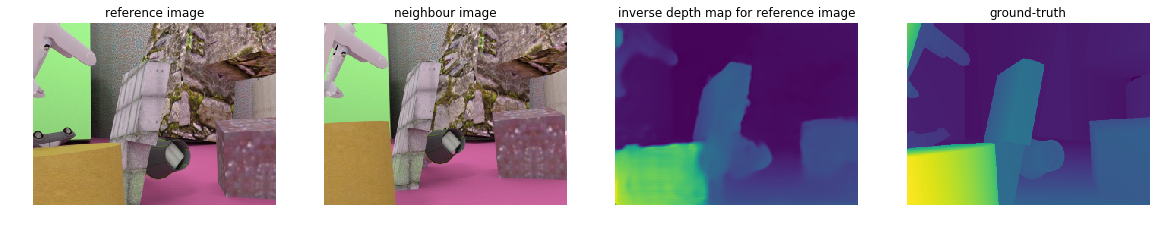

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title('reference image')
plt.imshow(cv2.imread('examples/0000.png'))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('neighbour image')
plt.imshow(cv2.imread('examples/0001.png'))
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('inverse depth map for reference image')
plt.imshow(pred_disp)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('ground-truth')
plt.imshow(1/imageio.imread('examples/0000.exr'))
plt.axis('off')